In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import json
pd.set_option('display.max_rows', 1000)
%matplotlib inline

In [97]:
# Read config
with open('config.json') as json_file:
    f = json.load(json_file)
    NUMBER_OF_QUERIES = f['number_of_queries']
    REPETITIONS = f['repetitions']
    ROWS = f['rows']
    SELECTIVITIES = [f['selectivity']]
    COLS = f['cols']
    EXPS_DEFAULTS = f['experiments']
    PARTITION_SIZE = f['partition_size']
    PROGRESSIVE_INDEX_DELTAS = f['deltas']

# Algorithms and Experiments defitions
algorithms = {
    'FullScan': {
        'name': 'full_scan_cl',
        'color': 'black',
        'dash': 'dot',
        'show_name': 'FS',
        'type': 'full_index',
        'partition_size': '0',
        'delta':'0.0',
    },
    'ProgressiveIndexTimeLimit': {
        'name': 'progressive_index_time_limit',
        'color': 'purple',
        'dash': 'dot',
        'show_name': 'GPFP(0.5)',
        'type': 'adaptive',
        'delta': PROGRESSIVE_INDEX_DELTAS[0],
        'partition_size': PARTITION_SIZE
    },
    'ProgressiveIndexQueryLimit': {
        'name': 'progressive_index_query_limit',
        'color': 'purple',
        'dash': 'solid',
        'show_name': 'GPFQ(10)',
        'type': 'adaptive',
        'delta': PROGRESSIVE_INDEX_DELTAS[0],
        'partition_size': PARTITION_SIZE
    },
    'ProgressiveIndexBelow': {
        'name': 'progressive_index_below',
        'color': 'black',
        'dash': 'solid',
        'show_name': 'PKD',
        'type': 'adaptive',
        'delta': PROGRESSIVE_INDEX_DELTAS[0],
        'partition_size': PARTITION_SIZE
    },
    'CrackingKDTree': {
        'name': 'cracking_kd_tree',
        'color': 'green',
        'dash': 'solid',
        'show_name': 'AKD',
        'type': 'adaptive',
        'delta': '0.0',
        'partition_size': PARTITION_SIZE
    }
}

for key, value in algorithms.items():
    name = value['name']
    delta = value['delta']
    partition_size = value['partition_size']
    algorithms[key]['alg_id'] = f"{name}-{delta}-{partition_size}"
    
# Synthetic Experiments
experiments = {}

for i in [2, 4, 8, 16]:
    temp = {
        f'Uniform{i}': {
            "name": f"Unif({i})",
            'name-in-file': 'uniform',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        }
    }
    experiments = {**experiments, **temp}
    
for key, value in experiments.items():
    name = value['name-in-file']
    rows = value['n_rows']
    n_queries = value['n_queries']
    cols = value['n_cols']
    sel = value['sel']
    experiments[key]['exp_id'] = f"{name}-{rows}-{n_queries}-{cols}-{sel}"

In [98]:
# Input/Output
def read(alg, exp):
    if exp.startswith('Shifting'):
        n_queries_per_run = 10
        uni = read(alg, 'Uniform' + experiments[exp]['n_cols'])
        n_runs = int(len(uni)/n_queries_per_run) - 1
        df_final = uni.head(n_queries_per_run)
        for _ in range(int(n_runs)):
            temp = uni.head(n_queries_per_run).copy()
            df_final = df_final.append(temp, ignore_index=True)
    else:
        df = pd.read_csv(f"results/{algorithms[alg]['alg_id']}-{experiments[exp]['exp_id']}.csv")
        repetitions = df['repetition'].max() + 1
        step = int(len(df.index)/repetitions)
        df_final = df[:step].copy().reset_index()
        for rep in range(1, repetitions):
            df_final += df[step * (rep) : step * (rep + 1)].copy().reset_index()

        df_final = df_final/repetitions
    
    if 'index_search_time' not in df_final:
        df_final['index_search_time'] = 0.0
    if 'tuples_scanned' not in df_final:
        df_final['tuples_scanned'] = 0.0
    if 'number_of_nodes' not in df_final:
        df_final['number_of_nodes'] = 0.0
    df_final['query_time'] = df_final['initialization_time'] + df_final['index_search_time'] + df_final['scan_time'] + df_final['adaptation_time']
    df_final['query_time_cumsum'] = df_final['query_time'].cumsum()
    return df_final

                     
def read_multiple(algs, exp):
    ''' Reads multiple algorithms in an experiment, return three arrays: dfs, colors, names
    '''
    dfs = []
    colors = []
    names = []
    dashes = []
    for alg in algs:
        dfs.append(read(alg, exp))
        names.append(algorithms[alg]['show_name'])
        colors.append(algorithms[alg]['color'])
        dashes.append(algorithms[alg]['dash'])
    
    return dfs, colors, dashes, names,

                     
def save_figure(fig, fig_name):
    fig.write_image(f"figures/{fig_name}", width=1024, height=768)
                     
def save_table(table, table_name):
    with open(f"tables/{table_name}", 'w') as f:
        f.write(table)

In [107]:
# Figures

def create_figure(data=[]):
    fig = go.Figure(
        data=data,
        layout=go.Layout(
#             width=1500,
            plot_bgcolor='rgba(0,0,0,0)',
            font=dict(
                size=42
            ),
            yaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgrey',
                zeroline=False,
                zerolinecolor='rgba(0, 0, 0, 0)',
                ticks="inside",
                ticklen=5
            ),
            xaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                ticks='inside',
                zeroline=True,
                ticklen=5
            ),
            legend=dict(
                font=dict(
                    size=30,
                    color="black"
                )
            )
        )
    )
    return fig

def per_query(exp, algs, limit=1000):
    dfs, colors, dashes, names = read_multiple(algs, exp)
    fig = create_figure()
    
    lines = []
    
    biggest = 0
    
    for i, df in enumerate(dfs):
        alg = algs[i]
        per_query_times = np.array(df['query_time'][:limit]) * 1000
        if biggest < np.max(per_query_times):
            biggest = np.max(per_query_times)
        lines.append(
            go.Scatter(
                name=names[i],
                x=list(range(len(per_query_times))),
                y=per_query_times,
                marker_color=colors[i],
                mode='lines',
                line=dict(width=6, dash=dashes[i])
            )
        )
        
    fig.add_traces(data=lines)
    fig.update_layout(showlegend=True, yaxis_title='Time (milliseconds)')
    fig.update_layout(legend_orientation="h", legend=dict(x=.05, y=1.2))
    fig.update_yaxes(type="log", range=[0, 4], tickvals=[0, 1, 10, 100, 1000, 10000])
    fig.update_xaxes(range=[0, 100], tickvals=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    return fig

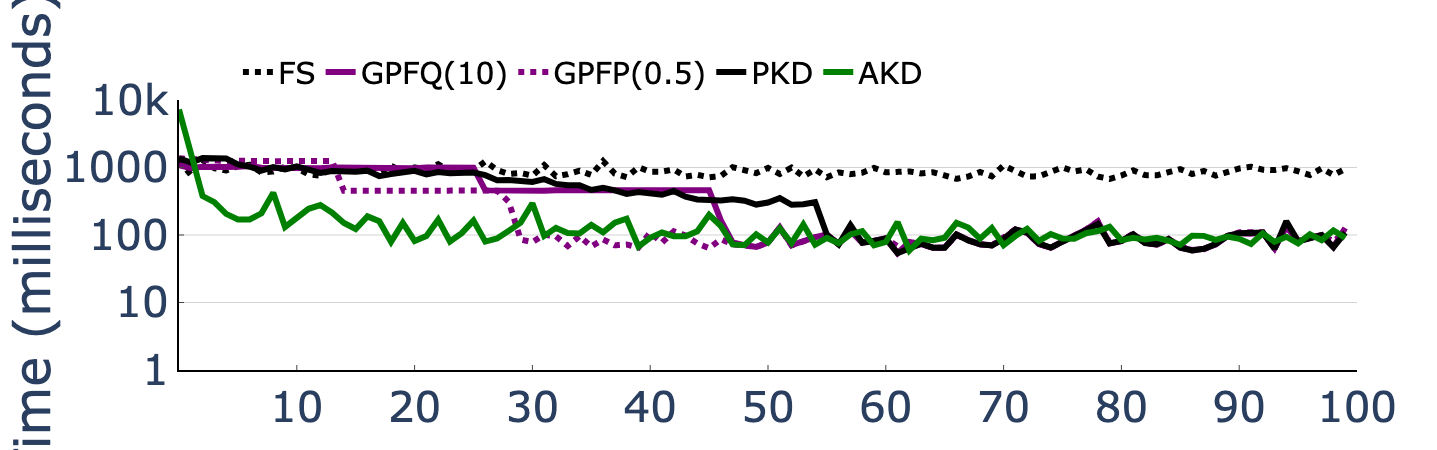

In [109]:
a = per_query('Uniform8', ['FullScan', 'ProgressiveIndexQueryLimit', 'ProgressiveIndexTimeLimit', 'ProgressiveIndexBelow', 'CrackingKDTree'], 100)
save_figure(a, 'over_interactive_threshold.pdf')
a